In [69]:
!pip install whisper 
!pip install pytube
!pip install jupyter-dash
!pip install plotly==4.4.1
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install jupyterlab-plotly
!pip install openai-whisper
!pip install librosa # added
!pip install matplotlib # added

  Using cached plotly-5.19.0-py3-none-any.whl.metadata (7.0 kB)
Using cached plotly-5.19.0-py3-none-any.whl (15.7 MB)
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
  Using cached plotly-4.4.1-py2.py3-none-any.whl.metadata (7.3 kB)
Using cached plotly-4.4.1-py2.py3-none-any.whl (7.3 MB)
  Attempting uninstall: plotly
    Found existing installation: plotly 5.19.0
    Uninstalling plotly-5.19.0:
      Successfully uninstalled plotly-5.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dash 2.16.1 requires plotly>=5.0.0, but you have plotly 4.4.1 which is incompatible.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional 

In [70]:
# Import necessary libraries
import os  # Import the os module
from os import name
import numpy as np
import librosa
import soundfile as sf
import whisper
import tempfile
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go
import IPython.display as ipd
from pytube import YouTube
%matplotlib inline
import matplotlib.pyplot as plt # added

# Outline:

1. Define the necessary functions.
    - Download the audio.
    - Load the audio.
    - Visualize the audio and detect the silence threshold.
    - Detect the silent and non-silent periods.
    - Transcribe the audio bearing in silent periods.
2. Demonstrate the process


## Define the necessary functions

### Download the audio file

In [71]:
def download_audio(youtube_url: str, file_name: str):
    """
    Downloads the audio from a YouTube video.

    Parameters:
    youtube_url (str): The URL of the YouTube video.
    file_name (str): The name of the file to save the audio as.

    Returns:
    None
    """
    # Create a YouTube object with the given URL
    yt = YouTube(youtube_url)

    # Filter the available streams to only include audio streams
    audio_stream = yt.streams.filter(only_audio=True).first()

    # Download the audio stream and save it to the specified file name
    audio_stream.download(filename=file_name)

### Load the audio.

In [72]:
# Load the audio file
def load_audio(file_name: str):
    """
    Loads an audio file into a numpy array.

    Parameters:
    file_name (str): The name of the file to load.

    Returns:
    np.ndarray: The audio data.
    int: The sample rate of the audio data.
    """
    # Load the audio file using librosa
    audio_data, sample_rate = librosa.load(file_name, sr=None)

    return audio_data, sample_rate

### Visualize the audio and detect the silence threshold.


In [73]:
# Visualize the audio
# Warning: On CPU, this function may take a long time to run for long audio files
def visualize_audio(y, sr, play = False, L = None) -> tuple[np.ndarray, int]:
    """
    Visualize an audio signal, calculate the mean magnitude for every group of 20 samples,
    and visualize the mean magnitude over time.

    Parameters:
        y (np.ndarray): The audio signal.
        sr (int): The sampling rate of the audio signal.
        L (np.ndarray): A 2D array where each row is a pair of values representing the start and end of a period.

    """

    # Calculate the mean magnitude for every group of 20 samples
    means = [np.mean(np.abs(y[i:i+20])) for i in range(0, len(y), 20)]
    means_db = librosa.amplitude_to_db(means)

    # Create sample count array for the means
    sample_index_means = np.arange(0, len(means)) * 20 / sr  # Convert to seconds

    # Create the plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=sample_index_means, y=means_db, mode='lines', name='Mean Magnitude'))
    # Add a horizontal line
    fig.add_trace(go.Scatter(x=[sample_index_means[0], sample_index_means[-1]], y=[min(means_db), min(means_db)], mode='lines', name='Threshold'))

    # Add vertical lines for each value in L
    if L is not None:
        for start, end in L:
            # Add a line at the start of the period
            fig.add_shape(
                type="line",
                x0=start,
                y0=min(means_db),
                x1=start,
                y1=max(means_db),
                line=dict(
                    color="Red",
                    width=2,
                    dash="dashdot",
                ),
            )
            # Add a line at the end of the period
            fig.add_shape(
                type="line",
                x0=end,
                y0=min(means_db),
                x1=end,
                y1=max(means_db),
                line=dict(
                    color="Red",
                    width=2,
                    dash="dashdot",
                ),
            )

    fig.update_layout(
        title='Mean Magnitude over Time',
        xaxis_title='Time (seconds)',
        yaxis_title='Mean Magnitude (dB)',
        width=1200,  # Width of the figure in pixels
        height=600   # Height of the figure in pixels
    )

    fig.show()

    if play == True:
        # listen to the audio file
        display(ipd.Audio(y, rate=sr))

In [74]:
# When GPU is available, use this function to visualize the audio
import matplotlib.pyplot as plt

def simple_visualize_audio(y, sr, save_path=None):
    """
    Visualize an audio signal and plot the mean magnitude over time.

    Parameters:
        y (np.ndarray): The audio signal.
        sr (int): The sampling rate of the audio signal.
        save_path (str): The path to save the graph (optional).

    Returns:
        None
    """
    # Calculate the mean magnitude for every group of 20 samples
    means = [np.mean(np.abs(y[i:i+20])) for i in range(0, len(y), 20)]
    means_db = librosa.amplitude_to_db(means)

    # Create sample count array for the means
    sample_index_means = np.arange(0, len(means)) * 20 / sr  # Convert to seconds

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(sample_index_means, means_db)
    plt.title('Mean Magnitude over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Mean Magnitude (dB)')

    if save_path:
        plt.savefig(save_path)  # Save the graph to the specified path

    plt.show()

### Detect the silent and non-silent periods.

In [75]:
def detect_periods(y: np.ndarray, sr: int, threshold: float) -> tuple:
    """
    Detect the periods of non-silence in the audio signal based on a given threshold.

    Parameters:
    y (np.ndarray): The audio signal.
    sr (int): The sample rate of the audio signal.
    threshold (float): The threshold value for detecting non-silence.

    Returns:
    tuple: A tuple containing three arrays.
        1st array: Non-silence .
        2nd array: Silent periods.
        3rd array: Periods as dictionaries with 'key = non-silence/silence' and 'value' fields.

    """
    unfiltered_non_silent_periods = librosa.effects.split(y, top_db=threshold)/sr
    silence = []
    for i in range(unfiltered_non_silent_periods.shape[0]-1):
        if unfiltered_non_silent_periods[i+1, 0] -unfiltered_non_silent_periods[i, 1] > 2:
            silence.append([unfiltered_non_silent_periods[i, 1]+0.5, unfiltered_non_silent_periods[i+1, 0]-0.5])

    silence = np.array(silence)  # Convert to numpy array

    # return complement of silence
    audio_length = len(y)/sr
    if silence.size > 0:  # Check if silence is not empty
        non_silence = np.array([[0, silence[0, 0]]])
        for i in range(silence.shape[0]-1):
            non_silence = np.append(non_silence, [[silence[i, 1], silence[i+1, 0]]], axis=0)
        non_silence = np.append(non_silence, [[silence[-1, 1], audio_length]], axis=0)
    else:
        non_silence = np.array([[0, audio_length]])

    # Merge non_silence and silence arrays and sort by start time
    periods = np.concatenate((non_silence, silence))
    periods = periods[periods[:, 0].argsort()]

    # Create set of non-silent periods
    non_silence_set = set(map(tuple, non_silence))

    # Create list of dictionaries
    # periods_dicts = [{'key': 'non-silence' if tuple(period) in non_silence_set else 'silence', 'value': period} for period in periods]
    # Create list of dictionaries
    periods_dicts = [{('non-silence' if tuple(period) in non_silence_set else 'silence'): period} for period in periods]

    return non_silence, silence, periods_dicts

### Transcribe the audio bearing in silent periods.


In [76]:
def transcribe_silence(y: np.ndarray, sr, periods_dictionaries: list, file_name: str, whisper_name="small", language="en"):
    """
    1. Checks and creates the ../data/input/text_transcribed directory if it does not exist.
    2. Opens a txt.file to write transcriptions.
    3. Iterates through all periods.
    4. If the period is silence, it writes "silence: ceiling of the length of the period in seconds".
    5. If the period is non-silence, it transcribes the audio and writes the transcription.
    6. Each transcription is written on a new line.
    7. Save the file with the specified file_name and close the file.

    params:
    y: numpy array, the original audio file that will be transcribed.
    sr: int, the sample rate of the audio file.
    periods_dictionaries: list of dictionaries, each period is a dictionary with one key-value pair
            period key: either 'silence' or 'non-silence'.
            period value: numpy array indicating the start and end time (in seconds).
    file_name: str, the name of the file where the transcriptions will be saved (without extension).
    whisper_name: str, the name of the whisper model to be used for the transcription.
    language: str, the language of the audio file.
    """
    model = whisper.load_model(whisper_name)

    # Define the directory path
    directory_path = "../data/input/text_transcribed"

    # Check if the directory exists, if not, create it
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # Ensure the file extension is .txt and prepend the directory path to the file name
    if not file_name.endswith('.txt'):
        file_name += '.txt'
    full_file_path = os.path.join(directory_path, file_name)

    with open(full_file_path, "w") as file:
        for period in periods_dictionaries:
            for period_type, times in period.items():
                start, end = times
                if period_type == "silence":
                    file.write(f"silence: {np.ceil(end - start)}\n")
                else:
                    with tempfile.NamedTemporaryFile(suffix=".wav", delete=True) as tmpfile:
                        sf.write(tmpfile, y[int(start*sr):int(end*sr)], sr)
                        tmpfile.flush()  # Make sure data is written to disk
                        result = model.transcribe(tmpfile.name, language=language)
                        file.write(result["text"] + "\n")



## 2. Demostrate the following steps:
- Download the audio.
- Load the audio.
- Visualize the audio and detect the silence threshold.
- Detect the silent and non-silent periods.
- Transcribe the audio bearing in silent periods.

In [77]:
# Download the audio file
url = "https://www.youtube.com/watch?v=9qXu-_sHy5Q"
file_name = "../data/input/audio/𝐀 𝐆𝐮𝐢𝐝𝐞𝐝 𝐌𝐞𝐝𝐢𝐭𝐚𝐭𝐢𝐨𝐧 𝐨𝐧 𝐭𝐡𝐞 𝐁𝐫𝐞𝐚𝐭𝐡 𝐚𝐧𝐝 𝐅𝐢𝐫𝐬𝐭 𝐉𝐡𝐚𝐧𝐚 - Ajahn Lee - Theravadin Forest Tradition.wav"

download_audio(url, file_name)


In [78]:
# Load the audio file
y, sr = load_audio(file_name)

/tmp/ipykernel_244106/4126078679.py:14: UserWarning:

PySoundFile failed. Trying audioread instead.

/home/solaris/miniconda3/envs/jhana-audio-transcription/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.



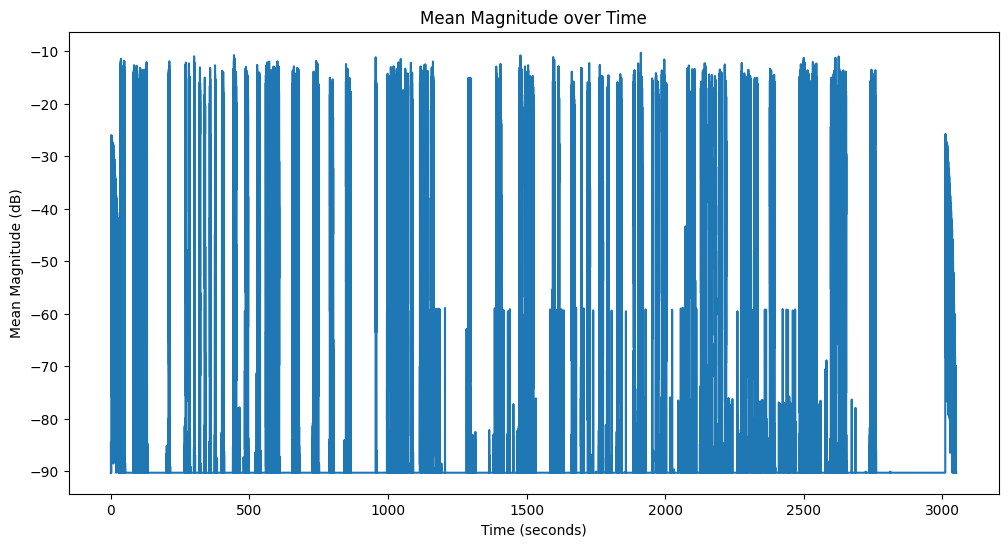

In [79]:
# Visualize the audio with the simple method
simple_visualize_audio(y, sr, save_path="../img/mean_magnitude_over_time_𝐀 𝐆𝐮𝐢𝐝𝐞𝐝 𝐌𝐞𝐝𝐢𝐭𝐚𝐭𝐢𝐨𝐧 𝐨𝐧 𝐭𝐡𝐞 𝐁𝐫𝐞𝐚𝐭𝐡 𝐚𝐧𝐝 𝐅𝐢𝐫𝐬𝐭 𝐉𝐡𝐚𝐧𝐚 - Ajahn Lee - Theravadin Forest Tradition.png")

In [80]:
# Set the threshold
threshold = 50.09

In [81]:
# Detect silent and non-silent periods
non_silent_periods, silent_periods, periods_dictionary = detect_periods(y, sr, threshold)
periods_dictionary

[{'non-silence': array([ 0.        , 38.75487528])},
 {'silence': array([38.75487528, 45.70770975])},
 {'non-silence': array([45.70770975, 50.92213152])},
 {'silence': array([50.92213152, 80.67696145])},
 {'non-silence': array([80.67696145, 90.37283447])},
 {'silence': array([90.37283447, 92.35659864])},
 {'non-silence': array([92.35659864, 96.21265306])},
 {'silence': array([ 96.21265306, 102.55015873])},
 {'non-silence': array([102.55015873, 104.15387755])},
 {'silence': array([104.15387755, 105.22045351])},
 {'non-silence': array([105.22045351, 106.76612245])},
 {'silence': array([106.76612245, 111.18798186])},
 {'non-silence': array([111.18798186, 114.47514739])},
 {'silence': array([114.47514739, 118.59514739])},
 {'non-silence': array([118.59514739, 121.85909297])},
 {'silence': array([121.85909297, 125.87460317])},
 {'non-silence': array([125.87460317, 131.20512472])},
 {'silence': array([131.20512472, 207.58562358])},
 {'non-silence': array([207.58562358, 212.82326531])},
 {'si

In [82]:
# Transcribe the audio and silence
file_name = "𝐀 𝐆𝐮𝐢𝐝𝐞𝐝 𝐌𝐞𝐝𝐢𝐭𝐚𝐭𝐢𝐨𝐧 𝐨𝐧 𝐭𝐡𝐞 𝐁𝐫𝐞𝐚𝐭𝐡 𝐚𝐧𝐝 𝐅𝐢𝐫𝐬𝐭 𝐉𝐡𝐚𝐧𝐚 - Ajahn Lee - Theravadin Forest Tradition.wav"
transcribe_silence(y, sr, periods_dictionary, file_name, "small", "en")